In [1]:
import sys
import os
import tqdm
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("./convex_hull"))

In [2]:
"""
Validation loss: 2.8789, trained on ~59.7B FineWeb-Edu tokens.
This is a base model and can frequently hallucinate.
"""

import json

from time import time

import torch
import torch.nn.functional as F
import tiktoken
from torch import nn

from safetensors import safe_open

from model_550m import FlashSTU, FlashSTUConfig, get_spectral_filters


CHECKPOINT_PATH = "../models/model_step-114000.safetensors"
CONFIG_PATH = "../models/config_2-7b.json"

/home/ds6237/.conda/envs/torch-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def apply_compile(model: nn.Module) -> None:
    """
    Apply torch.compile to each layer. This makes compilation efficient
    due to repeated structure. Alternatively, one can just compile the whole model.
    """
    print(f"Compiling each {model.__class__.__name__} layer with torch.compile...")
    start = time.perf_counter()
    for idx, layer in model.layers.named_children():
        compiled_layer = torch.compile(layer, mode="max-autotune", fullgraph=True)
        model.layers.register_module(idx, compiled_layer)
    end = time.perf_counter()
    print(f"Finished compiling each {model.__class__.__name__} layer in {end - start:.4f} seconds.")


def load_stu_model(config_path: str, checkpoint_path: str, device: torch.device):
    with open(config_path, "r") as f:
        config_data = json.load(f)

    dim = config_data["dim"]
    num_heads = config_data["num_heads"]
    num_layers = config_data["num_layers"]
    num_eigh = config_data["num_eigh"]
    seq_len = config_data["seq_len"]
    use_hankel_L = config_data["use_hankel_L"]
    window_size = config_data["window_size"]
    vocab_size = config_data["vocab_size"]
    mlp_scale = config_data["mlp_scale"]
    bias = config_data["bias"]
    dropout = config_data["dropout"]
    softcap = config_data["softcap"]
    theta = config_data["theta"]
    torch_compile = config_data["torch_compile"]
    torch_dtype = getattr(torch, config_data["torch_dtype"])

    model_config = FlashSTUConfig(
        dim=dim,
        num_heads=num_heads,
        num_layers=num_layers,
        seq_len=seq_len,
        window_size=window_size,
        vocab_size=vocab_size,
        mlp_scale=mlp_scale,
        bias=bias,
        dropout=dropout,
        softcap=softcap,
        theta=theta,
        torch_dtype=torch_dtype,
    )

    spectral_filters = get_spectral_filters(seq_len, num_eigh, use_hankel_L, device, torch_dtype)
    model = FlashSTU(model_config, spectral_filters)
    model = model.to(device=device, dtype=torch_dtype)

    print(f"Loading checkpoint from {checkpoint_path}...")
    state_dict = {}
    start_time = time()

    if checkpoint_path.endswith(".safetensors"):
        with safe_open(checkpoint_path, framework="pt", device=device.type) as f:
            for k in f.keys():
                state_dict[k] = f.get_tensor(k)
    elif checkpoint_path.endswith(".pt"):
        state_dict = torch.load(checkpoint_path, map_location="cpu")
    else:
        raise ValueError(f"Unsupported checkpoint format: {checkpoint_path}")
    print(f"Checkpoint loaded in {time() - start_time:.2f} seconds.")

    model.load_state_dict(state_dict, strict=True)
    print("Model weights loaded successfully!")

    if torch_compile:
        model = apply_compile(model)

    model.eval()

    return model, config_data


In [14]:
def generate_text(
    model,
    tokenizer,
    prompt,
    num_return_sequences=1,
    max_length=512,
    device="cuda",
    temperature=1.0,
    top_k=50,
    cache = True
):
    """
    Generate text from the given prompt using top-k sampling.

    Args:
        model: The FlashSTU model instance.
        tokenizer: The tokenizer used for encoding/decoding.
        prompt (str): Input prompt text.
        num_return_sequences (int): How many sequences to return.
        max_length (int): Maximum length of generated tokens.
        device: torch device.
        temperature (float): Sampling temperature. Higher = more random.
        top_k (int): Top-K sampling parameter.

    Returns:
        list[str]: A list of generated text sequences.
    """
    model.eval()

    # Encode prompt tokens.
    tokens = torch.tensor(
        [tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})],
        device=device,
    )
    seq_len = tokens.shape[1]
    tokens = tokens.repeat(num_return_sequences, 1)
    
    input_pos = torch.arange(seq_len, device=device)

    
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(1746)

    eos_token_id = tokenizer.encode(
        "<|endoftext|>", allowed_special={"<|endoftext|>"}
    )[0]
    cur_token = seq_len
    with torch.no_grad():
        for idx in tqdm.tqdm(range(max_length - tokens.size(1))):
            with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                # Fwd pass. Inspect logits here.
                if not cache:
                    logits = model(tokens)
                elif idx != 0:
                    logits = model(tokens[:, -1:], input_pos = input_pos)     # shape: [batch, 1, vocab]
                else:
                    logits = model(tokens, input_pos = input_pos)     # shape: [batch, seq, vocab]
                logits = logits[:, -1, :]  # last token logits

                # Apply temperature scaling.
                if temperature > 0:
                    logits = logits / temperature

            # Compute probabilities.
            probs = F.softmax(logits, dim=-1)

            # Top-K sampling.
            top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
            ix = torch.multinomial(top_k_probs, 1, generator=sample_rng)
            next_token = torch.gather(top_k_indices, -1, ix)

            # Append next token.
            tokens = torch.cat((tokens, next_token), dim=1)
            input_pos = torch.tensor([cur_token]).to(device)
            cur_token +=1 
            # Stop if EOS token is generated.
            # if (next_token == eos_token_id).any():
                # break

    # Decode all sequences.
    generated_sequences = []
    for i in range(num_return_sequences):
        decoded = tokenizer.decode(tokens[i].tolist())
        generated_sequences.append(decoded)

    return generated_sequences

In [15]:
from tiktoken.load import load_tiktoken_bpe
bpe_path = "../models/o200k_base.tiktoken"
bpe_dict = load_tiktoken_bpe(bpe_path)

tokenizer = tiktoken.Encoding(
    name="o200k_base",  # Name of the encoding
    pat_str=r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+""",
    mergeable_ranks=bpe_dict,
    special_tokens={
        "<|endoftext|>": 199999,  # Custom special token example (modify as needed)
        "<|endofprompt|>": 200018,
    }
)


In [16]:
device = torch.device("cuda")

# Load model and config.
model, config_data = load_stu_model(CONFIG_PATH, CHECKPOINT_PATH, device)
# tokenizer = tiktoken.get_encoding("o200k_base") #need to cache this for offline



Model Parameter Count: 550.31M

Loading checkpoint from ../models/model_step-114000.safetensors...
Checkpoint loaded in 0.22 seconds.
Model weights loaded successfully!


In [17]:
from torch.amp import autocast
from torch.nn import CrossEntropyLoss
import tqdm 

from dataloader import DataLoader

val_loader = DataLoader(
    bsz=1,
    seq_len= 128,
    dataset='../fineweb-edu', 
    split="val", 
    main_process=True,
)

def evaluate(model, val_steps = 5):
    loss_fn = CrossEntropyLoss()
    val_loss = 0.0
    torch_dtype = getattr(torch, 'bfloat16')
    # val_steps = 5 # Abitrarily set to reduce long evaluations, >20 typically used
    model.eval()
    val_loader.reset()
    with torch.no_grad():
        for i, batch in tqdm.tqdm(zip(range(val_steps), val_loader, strict=False)):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            if torch_dtype != torch.float32:
                with autocast(device_type=device.type, dtype=torch_dtype, cache_enabled=True):
                    preds = model(inputs)
            else:
                preds = model(inputs)

            loss = loss_fn(preds.flatten(0, 1), targets.flatten(0, 1))
            loss = loss / val_steps
            val_loss += loss.detach().float()
    return(val_loss)

2025-04-01 14:20:45,202 - INFO - Found 1 shards for split val


In [18]:
# Collect prompt(s) from user.
# prompts = []
# while True:
#     prompt = input("Enter a prompt (press enter with no text to finish): ")
#     if not prompt:
#         break
#     prompts.append(prompt.strip())

#     if len(prompts) == 0:
#         print("No prompts provided. Exiting.")
#         break

prompts = ['Obama is famous for']

# -------------------------------------------------------------------
# BASE SETTINGS:
BASE_TEMPERATURE = 0.7  # Increase for more randomness.
BASE_TOP_K = 50         # Limit sampling to the top k tokens.
MAX_LENGTH = 8000        # Maximum number of tokens to generate.
# -------------------------------------------------------------------
def generate_and_time(model, prompts, cache = True):
    total_tokens = 0
    start_time = time()
    
    for i, prompt in enumerate(prompts, 1):
        print(f"Generating text for prompt {i}: {prompt}")
        if cache:
            model.setup_caches(batch_size = 1)
        if not cache and model.caches_are_enabled():
            model.reset_caches()
            
        generated_texts = generate_text(
            model,
            tokenizer,
            prompt,
            num_return_sequences=1,
            max_length=MAX_LENGTH,
            device=device,
            temperature=BASE_TEMPERATURE,
            top_k=BASE_TOP_K,
            cache = cache
        )
        for gen_text in generated_texts:
            print(f"\nPrompt: {prompt}")
            print(f"Generated Text: {gen_text}\n")
            total_tokens += len(
                tokenizer.encode(gen_text, allowed_special={"<|endoftext|>"})
            )
        
        if cache:
            model.reset_caches()
    
    end_time = time()
    tokens_per_second = total_tokens / (end_time - start_time)
    print(f"Tokens per second: {tokens_per_second:.2f}")
generate_and_time(model, prompts, True)

#note that when stu is entirely removed, the speed is 145.89 it.s

Generating text for prompt 1: Obama is famous for


100%|██████████| 7996/7996 [02:04<00:00, 63.99it/s]


Prompt: Obama is famous for
Generated Text: Obama is famous for his efforts to create a perfect union between the two countries, and for his efforts on behalf of the poor, the homeless and the disabled. He also worked to bring about the abolition of child labour and the abolition of child labour in the Indian economy. Both were very important in terms of his contribution to the Indian economy.
The relationship between the two countries is not entirely harmonious, however. While some of the economic benefits accrued to the United States are obvious, others are more subtle. The United States is seen as a strong partner in providing basic necessities to the poor, while the Indian economy is seen as a weak partner. It is this dichotomy that has been the focus of much debate in recent years.
The American Indian community, for example, is often portrayed as a negative force in the Indian economy. This is partly due to the fact that the Indian economy is viewed as a source of income for many

In [19]:
evaluate(model, val_steps = 50)

50it [00:04, 11.70it/s]


tensor(3.3545, device='cuda:0')

In [23]:
from full_fast_stu import FullFastSTU
import copy

stu_before = []
stu_after = []

In [24]:
for idx in range(0, 12, 2):
    stu_layer = copy.deepcopy(model.layers[idx].stu)
    fast_layer = FullFastSTU(stu_layer.cuda(), "../experiments/convex_hull/best_phi_lds.pt").cuda()
    model.layers[idx].stu = fast_layer

    stu_before.append(stu_layer)
    stu_after.append(fast_layer)


/home/ds6237/stu_distill/experiments/convex_hull/full_fast_stu.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=to

In [25]:
evaluate(model, val_steps = 50)

50it [00:21,  2.32it/s]


tensor(3.3530, device='cuda:0')

In [26]:
generate_and_time(model, prompts, cache = True)

Generating text for prompt 1: Obama is famous for


100%|██████████| 7996/7996 [01:44<00:00, 76.32it/s]


Prompt: Obama is famous for
Generated Text: Obama is famous for his efforts to make the Great Recession a success. While he has not been the most visible of the four, he is one of the most important. He is the first black president and has been credited with changing the course of American history. One of the most important things Obama did during his presidency was to put a stop to the economic crisis, which has resulted in more than a million jobs being created and more than 2.5 million people being employed.
Obama has also made several other important public statements, including his statement in which he stated that he would not allow the federal government to take over the banks. In his statement he stated that he would not let the banks take over the banks, but would rather let them be controlled by the private sector. He also stated that he would not allow the government to impose taxes on the banks, but would allow the private sector to do so.
Obama has also made a number of o

In [27]:
generate_and_time(model, prompts, cache = False)

Generating text for prompt 1: Obama is famous for


  1%|          | 73/7996 [00:10<18:27,  7.16it/s]

KeyboardInterrupt



In [28]:

import torch.nn.functional as F
gaps = []
with torch.no_grad():
    for i in range(6):
        x = torch.randn(1,100,896).cuda()
        input_pos = torch.arange(100, device=device)
        
        stu_out = stu_before[i](x.bfloat16(), input_pos)
        lds_out = stu_after[i](x.bfloat16(), input_pos)
        print(F.l1_loss(stu_out, lds_out))
        gaps.append((stu_out - lds_out).abs().cpu().detach().float().flatten())
        #F1 of approx 0.005 between stu with lds filters and lds. That's pretty high error

tensor(0.0006, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0021, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0038, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0045, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0040, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0043, device='cuda:0', dtype=torch.bfloat16)


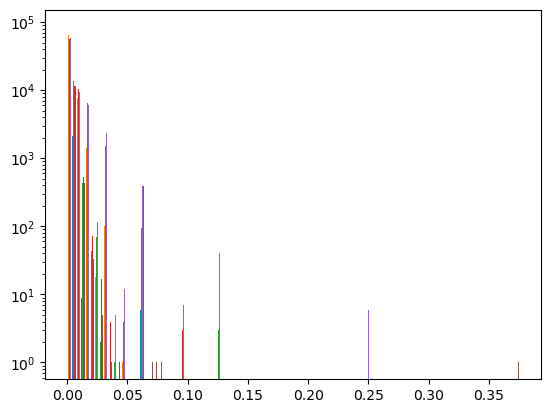

In [29]:
import matplotlib.pyplot as plt

_ = plt.hist(gaps, bins = 100, log = True)
# plt.xscale('log')
plt.show()